In [17]:
# calc_classification.py
import matplotlib as mpl
mpl.rcParams['font.family'] = 'DejaVu Sans'
# 필요하다면 sans-serif 계열을 강제 지정
mpl.rcParams['font.sans-serif'] = ['DejaVu Sans']
import sys
# classification 패키지가 있는 상위 폴더를 직접 지정
sys.path.insert(0, "/home/cseomoon/appl/af_analysis-0.1.4/model")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pycaret.classification import (
    setup, compare_models, finalize_model,
    predict_model, pull, plot_model
)
from sklearn.metrics import (
    roc_auc_score, accuracy_score, f1_score,
    confusion_matrix, classification_report,
    precision_recall_curve, average_precision_score,
    roc_curve
)

from classification.utils.data_loader import load_and_preprocess_data

def main():
    # 1) 경로 정의
    train_fp = "/home/cseomoon/appl/af_analysis-0.1.4/model/classification/data/train/AbNb_final_h3_l3_plddt_20250522.csv"
    test_fp  = "/home/cseomoon/appl/af_analysis-0.1.4/model/classification/data/test/ABAG_final_h3_plddt_20250522.csv"
    
    # 2) 데이터 로드 및 전처리
    X_train, y_train, groups = load_and_preprocess_data(
        train_fp,
        target_column="DockQ",
        threshold=0.23,
        query_id_column="query"
    )
    X_test, y_test, _ = load_and_preprocess_data(
        test_fp,
        target_column="DockQ",
        threshold=0.23,
        query_id_column="query"
    )
    
    # 3) DataFrame 생성
    train_df = X_train.copy()
    train_df["target"] = y_train.values
    test_df = X_test.copy()
    test_df["target"] = y_test.values
    
    # 4) PyCaret 설정 (5-Fold 그룹KFold, GPU 사용, 정규화)
    clf_setup = setup(
        data=train_df,
        target="target",
        session_id=42,
        fold_strategy="groupkfold",
        fold=5,
        fold_groups=groups,
        normalize=True,
        use_gpu=False,
        verbose=False,
        log_experiment=False
    )
    
    # 5) 모델 비교 및 선택 (전체 모델 대상, 내부 CV 결과 확인)
    top3 = compare_models(
        n_select=3,
        sort="AUC"
    )
    print("=== Top 3 모델 (내부 5-Fold CV) ===")
    print(pull().head(5))
    
    # 6) 최상위 모델 최종화
    best = top3[0]
    final_model = finalize_model(best)
    
    # 7) 내부 CV 성능 시각화 (ROC, PR, Confusion Matrix, Feature Importance)
    plot_model(final_model, plot="auc", save=True)
    plot_model(final_model, plot="pr", save=True)
    plot_model(final_model, plot="confusion_matrix", save=True)
    plot_model(final_model, plot="feature", save=True)
    
    # 8) 외부 테스트셋 피처 정렬
    feature_cols = train_df.columns.difference(["target"])
    for c in feature_cols:
        if c not in test_df.columns:
            test_df[c] = 0
    test_aligned = test_df[feature_cols]
    
    # 9) 외부 테스트셋 예측
    pred = predict_model(final_model, data=test_aligned)
    
    # 10) 예측 결과 컬럼 찾기
    new_cols = [c for c in pred.columns if c not in test_aligned.columns]
    prob_cols = [c for c in new_cols if any(kw in c.lower() for kw in ("score","prob","proba"))]
    if not prob_cols:
        raise ValueError(f"확률 컬럼을 찾을 수 없습니다: {new_cols}")
    y_pred_proba = pred[prob_cols[-1]].values
    
    label_cols = [c for c in new_cols if c not in prob_cols]
    if not label_cols:
        raise ValueError(f"예측 라벨 컬럼을 찾을 수 없습니다: {new_cols}")
    y_pred = pred[label_cols[0]].values
    
    # 11) 외부 테스트셋 평가 지표 출력
    auc  = roc_auc_score(y_test, y_pred_proba)
    acc  = accuracy_score(y_test, y_pred)
    f1   = f1_score(y_test, y_pred)
    cm   = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    
    print("\n=== External Test Set Evaluation ===")
    print(f"AUC      : {auc:.4f}")
    print(f"Accuracy : {acc:.4f}")
    print(f"F1-score : {f1:.4f}")
    print("\nConfusion Matrix:")
    print(cm)
    print("\nClassification Report:")
    print(report)
    
    # 12) Precision-Recall Curve (외부 테스트)
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = average_precision_score(y_test, y_pred_proba)
    plt.figure()
    plt.plot(recall, precision, label=f"PR AUC={pr_auc:.2f}")
    plt.hlines(y=y_test.mean(), xmin=0, xmax=1, linestyles="--", label="baseline")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision–Recall Curve (External Test)")
    plt.legend()
    plt.grid()
    plt.savefig("pr_curve_external.png")
    plt.close()
    
    # 13) ROC Curve (외부 테스트)
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.figure()
    plt.plot(fpr, tpr, label=f"ROC AUC={auc:.2f}")
    plt.plot([0,1], [0,1], linestyle="--", label="chance")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve (External Test)")
    plt.legend()
    plt.grid()
    plt.savefig("roc_curve_external.png")
    plt.close()

if __name__ == "__main__":
    main()

Original data shape: (3650, 89)
Class distribution before NaN drop (DockQ >= 0.23): 0 (Negative) = 2529, 1 (Positive) = 1121
'LIS' column not found in the data.
Identified 67 potential feature columns.
Checking for NaN values in potential feature columns...
Dropped 3 rows containing NaN values in one or more feature columns.
Processed Features (X) shape after NaN drop: (3647, 67)
Processed Target (y) shape after NaN drop: (3647,)
Processed Query IDs shape after NaN drop: (3647,)
Class distribution after NaN drop (DockQ >= 0.23): 0 (Negative) = 2526, 1 (Positive) = 1121
Original data shape: (1650, 84)
Class distribution before NaN drop (DockQ >= 0.23): 0 (Negative) = 1022, 1 (Positive) = 628
Found 'LIS' column in the data. It will be dropped from features.
Identified 61 potential feature columns.
Checking for NaN values in potential feature columns...
Dropped 2 rows containing NaN values in one or more feature columns.
Processed Features (X) shape after NaN drop: (1648, 61)
Processed Ta

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.9016,0.9554,0.7883,0.8980,0.8271,0.7584,0.7722,0.4300
catboost,CatBoost Classifier,0.8930,0.9544,0.7991,0.8715,0.8149,0.7398,0.7572,2.6400
lightgbm,Light Gradient Boosting Machine,0.8871,0.9517,0.7780,0.8372,0.7954,0.7168,0.7275,124.5600
ridge,Ridge Classifier,0.8961,0.9458,0.8176,0.8523,0.8302,0.7546,0.7589,0.3820
lda,Linear Discriminant Analysis,0.8949,0.9432,0.8176,0.8492,0.8287,0.7522,0.7564,0.3780
xgboost,Extreme Gradient Boosting,0.8774,0.9415,0.7939,0.8028,0.7846,0.6981,0.7109,0.4220
rf,Random Forest Classifier,0.8846,0.9407,0.7695,0.8343,0.7880,0.7085,0.7207,0.4800
lr,Logistic Regression,0.8839,0.9372,0.8476,0.8053,0.8174,0.7328,0.7408,1.0760
nb,Naive Bayes,0.8916,0.9366,0.7897,0.8574,0.8091,0.7338,0.7463,0.3680
gbc,Gradient Boosting Classifier,0.8560,0.9324,0.7571,0.7894,0.7571,0.6551,0.6691,0.8780


=== Top 3 모델 (내부 5-Fold CV) ===
                                    Model  Accuracy     AUC  Recall   Prec.  \
et                 Extra Trees Classifier    0.9016  0.9554  0.7883  0.8980   
catboost              CatBoost Classifier    0.8930  0.9544  0.7991  0.8715   
lightgbm  Light Gradient Boosting Machine    0.8871  0.9517  0.7780  0.8372   
ridge                    Ridge Classifier    0.8961  0.9458  0.8176  0.8523   
lda          Linear Discriminant Analysis    0.8949  0.9432  0.8176  0.8492   

              F1   Kappa     MCC  TT (Sec)  
et        0.8271  0.7584  0.7722     0.430  
catboost  0.8149  0.7398  0.7572     2.640  
lightgbm  0.7954  0.7168  0.7275   124.560  
ridge     0.8302  0.7546  0.7589     0.382  
lda       0.8287  0.7522  0.7564     0.378  



=== External Test Set Evaluation ===
AUC      : 0.4087
Accuracy : 0.9296
F1-score : 0.9035

Confusion Matrix:
[[989  31]
 [ 85 543]]

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.97      0.94      1020
           1       0.95      0.86      0.90       628

    accuracy                           0.93      1648
   macro avg       0.93      0.92      0.92      1648
weighted avg       0.93      0.93      0.93      1648



In [19]:
clf_setup

NameError: name 'clf_setup' is not defined

### 디버깅용

Original data shape: (3650, 89)
Class distribution before NaN drop (DockQ >= 0.23): 0 (Negative) = 2529, 1 (Positive) = 1121
'LIS' column not found in the data.
Identified 67 potential feature columns.
Checking for NaN values in potential feature columns...
Dropped 3 rows containing NaN values in one or more feature columns.
Processed Features (X) shape after NaN drop: (3647, 67)
Processed Target (y) shape after NaN drop: (3647,)
Processed Query IDs shape after NaN drop: (3647,)
Class distribution after NaN drop (DockQ >= 0.23): 0 (Negative) = 2526, 1 (Positive) = 1121
Original data shape: (1650, 84)
Class distribution before NaN drop (DockQ >= 0.23): 0 (Negative) = 1022, 1 (Positive) = 628
Found 'LIS' column in the data. It will be dropped from features.
Identified 61 potential feature columns.
Checking for NaN values in potential feature columns...
Dropped 2 rows containing NaN values in one or more feature columns.
Processed Features (X) shape after NaN drop: (1648, 61)
Processed Ta

[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset migh

[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset migh

[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.8803,0.9315,0.7103,0.8918,0.7737,0.6900,0.7079,0.3700
lightgbm,Light Gradient Boosting Machine,0.8843,0.9302,0.7707,0.8608,0.8089,0.7226,0.7275,0.2367
lr,Logistic Regression,0.8627,0.8940,0.7178,0.8206,0.7636,0.6630,0.6671,0.0333


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

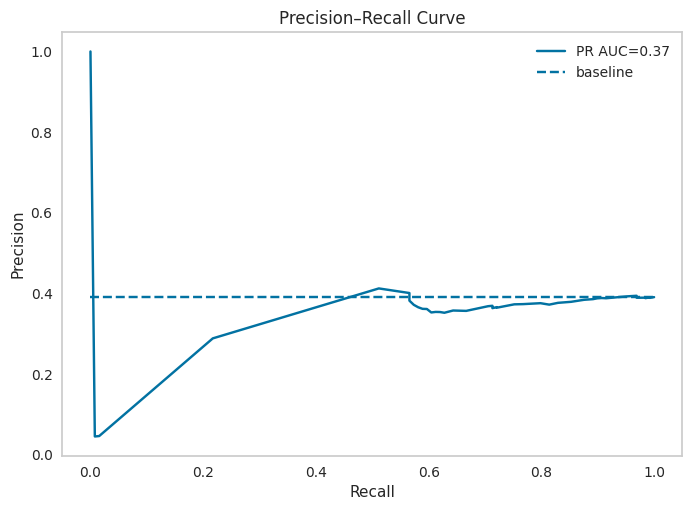

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

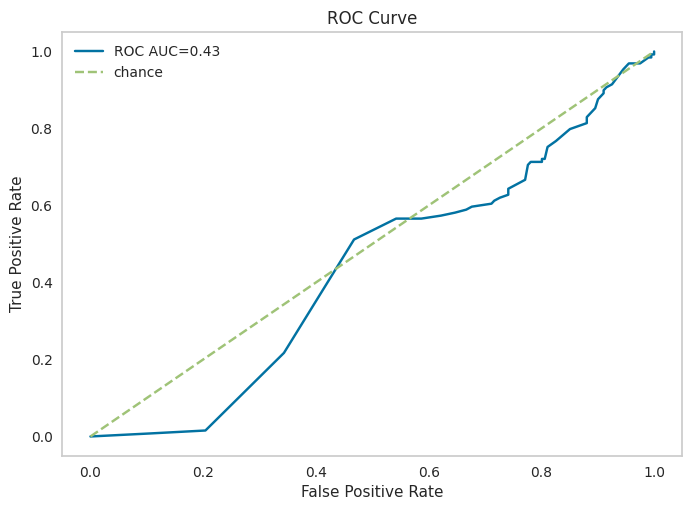

In [15]:
# calc_classification.py
import sys
sys.path.insert(0, "/home/cseomoon/appl/af_analysis-0.1.4/model")

import pandas as pd
import numpy as np

from pycaret.classification import (
    setup, compare_models, finalize_model,
    predict_model, pull,
    plot_model,    # ← 이미 추가된 부분
    evaluate_model # ← 이미 추가된 부분
)
from sklearn.metrics import (
    roc_auc_score, accuracy_score,
    f1_score, confusion_matrix, classification_report
)
from classification.utils.data_loader import load_and_preprocess_data

def main():
    # 1) 경로 정의
    train_fp = "/home/cseomoon/appl/af_analysis-0.1.4/model/classification/data/train/AbNb_final_h3_l3_plddt_20250522.csv"
    test_fp  = "/home/cseomoon/appl/af_analysis-0.1.4/model/classification/data/test/ABAG_final_h3_plddt_20250522.csv"
    
    # 2) 데이터 로드 및 전처리
    X_train, y_train, groups = load_and_preprocess_data(
        train_fp, target_column='DockQ', threshold=0.23, query_id_column='query'
    )
    X_test,  y_test,  _      = load_and_preprocess_data(
        test_fp,  target_column='DockQ', threshold=0.23, query_id_column='query'
    )
    
    # 3) DataFrame 준비
    train_df = X_train.copy()
    train_df['target'] = y_train.values
    test_df  = X_test.copy()
    test_df['target'] = y_test.values
    
    # 4) 디버깅용 샘플링 20%
    train_df_small = train_df.sample(frac=0.2, random_state=42)
    test_df_small  = test_df.sample(frac=0.2, random_state=42)
    groups_small   = groups.loc[train_df_small.index]

    # 5) setup (3-Fold, GPU, normalize)
    clf_setup = setup(
        data=train_df_small,
        target='target',
        session_id=42,
        fold_strategy='groupkfold',
        fold=3,
        fold_groups=groups_small,
        normalize=True,
        use_gpu=True,
        verbose=False,
        log_experiment=False
    )

    # 6) 모델 비교 (turbo, 특정 모델만)
    top3 = compare_models(
        n_select=3,
        sort='AUC',
        include=['lightgbm','rf','lr'],
        turbo=True,
        fold=3
    )
    best = top3[0]
    final_model = finalize_model(best)

    # 7) 테스트셋 컬럼 정렬 맞추기
    feature_cols = train_df_small.columns.difference(['target'])
    for c in feature_cols:
        if c not in test_df_small.columns:
            test_df_small[c] = 0
    test_aligned = test_df_small[feature_cols]

    # 8) 예측
    pred = predict_model(final_model, data=test_aligned)

    # 9) 샘플링된 실제 레이블, 예측 확률 추출
    y_test_small       = test_df_small['target'].values
    # predict_model() 가 추가한 컬럼 중에 확률 컬럼만 골라서
    new_cols = [c for c in pred.columns if c not in test_aligned.columns]
    prob_cols = [c for c in new_cols if any(kw in c.lower() for kw in ('score','prob','proba'))]
    y_pred_proba_small = pred[prob_cols[-1]].values

    # 10) PR / ROC 커브 그리기
    from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, roc_auc_score
    import matplotlib.pyplot as plt

    # Precision-Recall
    precision, recall, _ = precision_recall_curve(y_test_small, y_pred_proba_small)
    pr_auc = average_precision_score(y_test_small, y_pred_proba_small)
    plt.figure()
    plt.plot(recall, precision, label=f'PR AUC={pr_auc:.2f}')
    plt.hlines(y=y_test_small.mean(), xmin=0, xmax=1, linestyles='--', label='baseline')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision–Recall Curve')
    plt.legend()
    plt.grid()
    plt.show()

    # ROC
    fpr, tpr, _ = roc_curve(y_test_small, y_pred_proba_small)
    roc_auc = roc_auc_score(y_test_small, y_pred_proba_small)
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC AUC={roc_auc:.2f}')
    plt.plot([0,1], [0,1], linestyle='--', label='chance')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid()
    plt.show()

    # 11) (원하면) 기타 plot_model 호출
    # plot_model(final_model, plot='confusion_matrix', save=True)
    # plot_model(final_model, plot='feature', save=True)

if __name__ == "__main__":
    main()